## **5. DIAGNOSTIC DATA ANALYSIS**  
After the Descriptive analysis phase it is clear the BNTP trading strategy is not losing due to poor risk management, but due to its poor predictive capability.  
Losses are effectively cut but winning trades aren't large enough or frequent enough to turn a profit.  
The strategy is not particularly winning or losing significant amount of money.   

   
The Descriptive phase answered **"what"** happened in the past in terms of the strategy and its performance metrics.  
It concluded that the strategy lost money generally. However it performed well for specific combinations.  
This phase of analysis will provide insight into the **"reasons why"** strategy resulted in the performance metrics it did over the past year.  

The insight gathered will further bolster the findings of the Descriptive analysis, and better optimize the strategy by identifying inefficiencies in the strategy that causing losses and understanding how to mitigate them.  

In [1]:
# import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from typing import Union, List, Dict, Any, Optional
import math

from pandas.api.types import is_datetime64_any_dtype, is_object_dtype, is_string_dtype,is_numeric_dtype

### **5.1.0 Diagnosis of Predictive Capability Failure**   
This initial section targets the fundamental market edge and questioning the validity of the trading signals.  
It has been established that the strategy is not losing due to reckless risk management, but rather due to a deficit in winning trades—they are either not large enough or not frequent enough to overcome effectively managed losses.  


This diagnostic journey will drill deep into the raw trade data, examining the relationship between specific entry and confirmation signals, the prevailing market conditions (volatility/session), and the resulting trade outcomes to precisely determine why the predictive mechanism fails to translate good risk management into consistent profitability. This will isolate the specific trade elements(variables) that require recalibration for true strategic optimization. 

In [3]:
dataframe = pd.read_csv('gbpusd_data_updated.csv')
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 30 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trade_open             102 non-null    object 
 1   Trade_close            102 non-null    object 
 2   Session                102 non-null    object 
 3   Position               102 non-null    object 
 4   Bias                   102 non-null    object 
 5   Profile                102 non-null    object 
 6   Entry                  102 non-null    object 
 7   Confirmation           102 non-null    object 
 8   Fvg_level              51 non-null     object 
 9   Stop_loss_pips         102 non-null    float64
 10  Take_profit_pips       102 non-null    float64
 11  Risk_to_reward         102 non-null    float64
 12  Risk_usd               102 non-null    float64
 13  Profit_loss            102 non-null    float64
 14  Trail_stop             102 non-null    object 
 15  Outcom

### **5.1.1 Comparative Analysis: Wins vs. Losses**   
This analysis will compare wins and losses to find structural differences that explain the lack of profitability.
To understand this the comparison of the mean, median and variance of the winning and losing trades is essential against significant columns.    

**a.) Wins vs Losses under Risk to reward**  
Since the aim is to understand whether wins are not large enough or frequent enough, the **Risk_to_reward** column is chosen because it is the most direct mathematical representation of the predictive intent regarding trade profitability, making it the most critical metric for diagnosing a predictive capability failure.

In [5]:
# Return the mean, median, and standard deviation of Risk_to_reward for each outcome group
outcome_statistics_for_rr = dataframe.groupby('Outcome')['Risk_to_reward'].agg(['mean', 'median', 'std'])
outcome_statistics_for_rr = (outcome_statistics_for_rr
                             .T
                             .reset_index()
                             .rename(columns={'index': 'Statistic'})
                             .melt(id_vars='Statistic', var_name='Outcome', value_name='RR_value'))

In [56]:
outcome_statistics_for_rr

,Statistic,Outcome,RR_value
0,mean,loss,2.723406
1,median,loss,2.500000
2,std,loss,0.710604
3,mean,win,2.696684
4,median,win,2.700000
5,std,win,0.885713


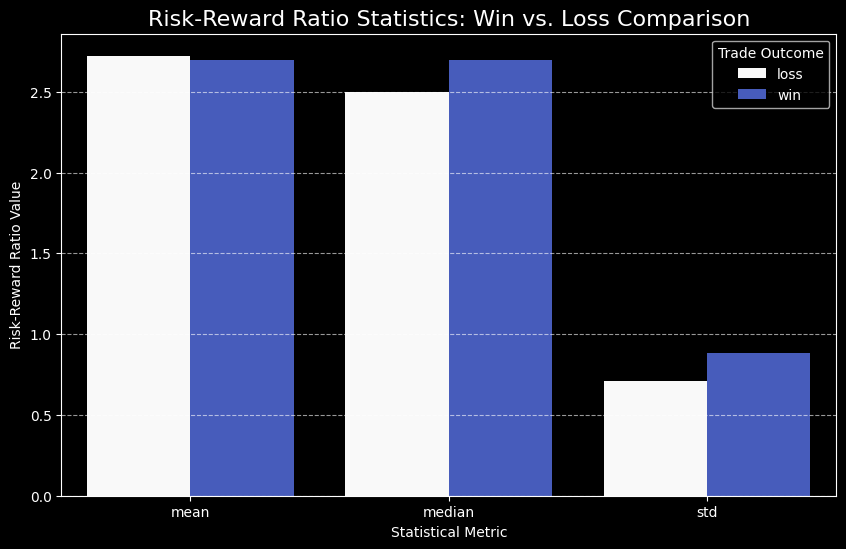

In [57]:
plt.figure(figsize=(10, 6))
sns.barplot(
    data=outcome_statistics_for_rr,
    x='Statistic',   
    y='RR_value',   
    hue='Outcome',   
    palette=['#f9f9f9', '#3450ce']
)

plt.title('Risk-Reward Ratio Statistics: Win vs. Loss Comparison', fontsize=16)
plt.xlabel('Statistical Metric')
plt.ylabel('Risk-Reward Ratio Value')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title='Trade Outcome')
plt.show()

The higher risk to reward ratio for median wins against losses indicates the strategy's edge is only marginally better at identifying potential win setups.  
However the standard deviation of risk to reward ratio for wins is larger than for losses.   
This suggests that while some winning trades are profitable, many are not sufficiently large to cover losses.  

The higher mean risk to reward for losses suggests losing trades contain significant high risk to reward outliers driving the mean up.  
Suggesting the failure of predictive capability is because the signals are mostly incorrect when they set the most ambitious targets.  

The strategy overconfidently identifies high risk to reward setups that turn to losses, a key reason for overall underperformance.

**b.) Win Rate by Day and Session**  
The market environment is crucial for uncovering predictive weaknesses. This comparative analysis will drill into the categorical time data, **`Day` and `Session`**, because these two variables define the prevailing liquidity and volatility regimes that critically impact trade success. 

By calculating and comparing the **Win Rate** across each day of the week and each global trading session, we aim to isolate precisely when the strategy's predictive edge vanishes or, conversely, where it is strongest.

In [ ]:
# Group by 'Outcome', 'Day', and 'Session' to get counts
time_based_outcome = dataframe.groupby('Outcome')[['Day', 'Session']].value_counts()
time_based_outcome = time_based_outcome.to_frame().reset_index()
time_based_outcome

In [69]:
# Pivot data to get counts of Wins and Losses per Day and Session
time_based_pivot = time_based_outcome.pivot_table(
    index=['Day', 'Session'],
    columns='Outcome',
    values='count',
    fill_value=0
).reset_index()

In [73]:
# calculate total trades
time_based_pivot['Total_trades'] = time_based_pivot['win'] + time_based_pivot['loss']

# calculate win rate
time_based_pivot['Win_rate'] = round(time_based_pivot['win'] / time_based_pivot['Total_trades'], 2)

In [79]:
time_based_pivot['day_&_session'] = time_based_pivot['Day'] + ' ' + time_based_pivot['Session']

In [80]:
time_based_pivot

Outcome,Day,Session,loss,win,Total_trades,Win_rate,day_&_session
0,Friday,ny am,12.0,8.0,20.0,0.40,Friday ny am
1,Friday,ny pm,2.0,0.0,2.0,0.00,Friday ny pm
2,Monday,ny am,6.0,4.0,10.0,0.40,Monday ny am
3,Monday,ny pm,1.0,1.0,2.0,0.50,Monday ny pm
4,Thursday,ny am,17.0,6.0,23.0,0.26,Thursday ny am
5,Thursday,ny pm,1.0,0.0,1.0,0.00,Thursday ny pm
6,Tuesday,ny am,14.0,8.0,22.0,0.36,Tuesday ny am
7,Tuesday,ny pm,4.0,1.0,5.0,0.20,Tuesday ny pm
8,Wednesday,ny am,9.0,3.0,12.0,0.25,Wednesday ny am
9,Wednesday,ny pm,5.0,0.0,5.0,0.00,Wednesday ny pm


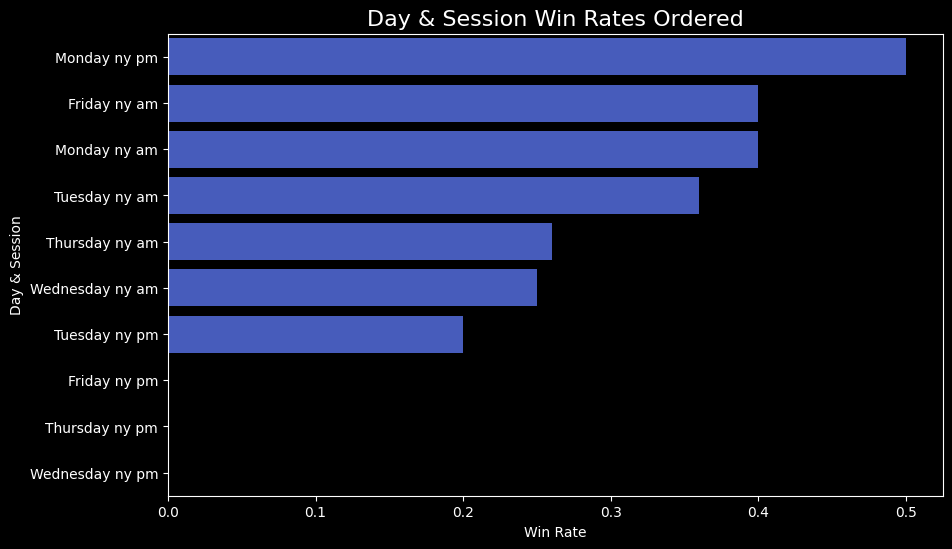

In [85]:
# Visualize outcome
plt.figure(figsize=(10, 6))
sns.barplot(
    data=time_based_pivot.sort_values(by='Win_rate', ascending=False),
    x='Win_rate',   
    y='day_&_session',
    color='#3450ce'
)

plt.title('Day & Session Win Rates Ordered', fontsize=16)
plt.xlabel('Win Rate')
plt.ylabel('Day & Session')
plt.show()

This diagnostic reveals the strategy's predictive edge is dependent on specific days and sessions, highlighting optimal trading times while identifying periods of complete failure.  

All the NY A.M sessions show positive, albeit low win rates (25%-40%) across the trading days.  
However, the NY P.M session besides Monday show 20% or less win rates. This diagnoses the root cause of loss aggregation: the strategy is being applied indiscriminately during low-liquidity, high-risk, or low-volatility periods.  

The time slots with 0% Win Rate are the clearest diagnosis of failure.  
Continuing to trade on Wednesday PM, Thursday PM, and Friday PM is mathematically guaranteed to contribute $100\%$ to the total loss count.

Even within the relatively "successful" NY AM session, the Win Rate is inconsistent, ranging from a decent 40% (Monday, Friday) down to a weak 25% (Wednesday). This indicates that even when liquidity is high, the predictive edge is fragile and likely vulnerable to specific weekly events

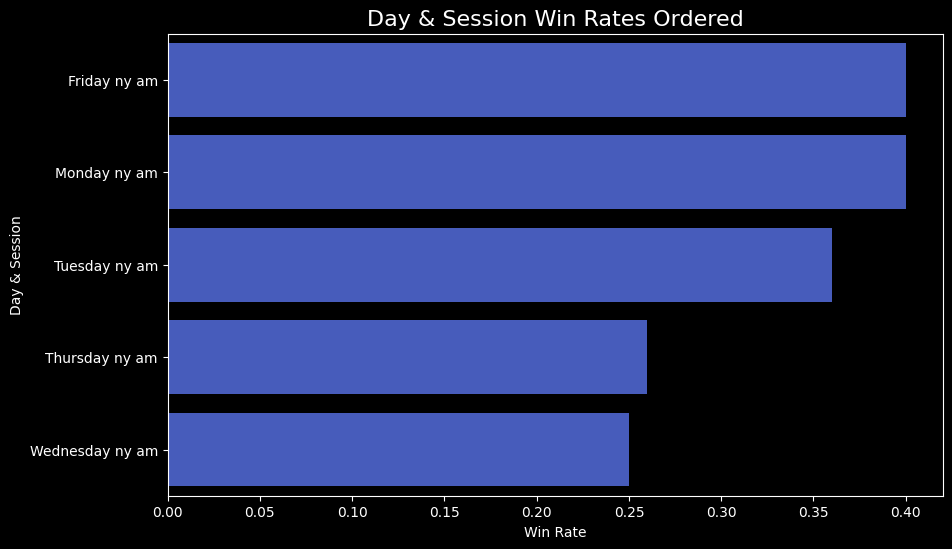

In [ ]:
# Revisualization of outcome filtered based on total trades > 5
plt.figure(figsize=(10, 6))
sns.barplot(
    data=time_based_pivot[time_based_pivot['Total_trades'] > 5].sort_values(by='Win_rate', ascending=False),
    x='Win_rate',   
    y='day_&_session',
    color='#3450ce'
)

plt.title('Day & Session Win Rates Ordered Revisualized', fontsize=16)
plt.xlabel('Win Rate')
plt.ylabel('Day & Session')
plt.show()

Due to the low number of trades in some **Day & Session** combinations the win rates may not be statistically reliable.  
Hence the revisualization above filters out combinations with total trades less than 5 to provide a clearer picture of performance during more active periods.  

This revisualization shows the NY AM **Session** across all days has consistently low but positive win rates. This is statistically more reliable and an actionable finding.  
It appears Friday, Monday and Tuesday NY AM sessions had win rates above 35%.  
However, Thursday and Wednesday NY AM sessions had win rates less than 30%, showing these days have a reliable measurement of low performance.

**c.) Analysis of Volatility: Wins vs Losses**  
This will use the range of each trading day's activity in pips.  
The analysis is aimed at providing insight in the strategy's performance during different volatility levels in the market under both winning and losing trades.

- **Measures of Central Tendency and Dispersion**

In [204]:
outcome_statistics_volatility = dataframe.groupby('Outcome')['pip_range'].agg(['mean', 'median', 'std'])
outcome_statistics_volatility = (outcome_statistics_volatility
                             .T
                             .reset_index()
                             .rename(columns={'index': 'Statistic'})
                             .melt(id_vars='Statistic', var_name='Outcome', value_name='pip_range')
                             )

outcome_statistics_volatility

,Statistic,Outcome,pip_range
0,mean,loss,66.975714
1,median,loss,60.300000
2,std,loss,25.398764
3,mean,win,68.686667
4,median,win,69.350000
5,std,win,33.559928


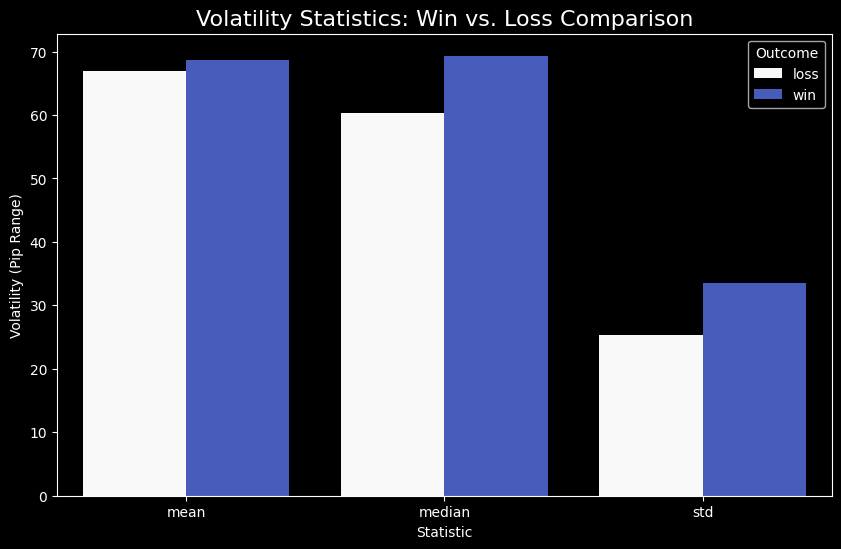

In [208]:
# Visualization of Volatility against Outcome
plt.figure(figsize=(10, 6))
sns.barplot(
    data=outcome_statistics_volatility,
    x='Statistic',   
    y='pip_range',
    hue='Outcome',
    palette=['#f9f9f9', '#3450ce']
)

plt.title('Volatility Statistics: Win vs. Loss Comparison', fontsize=16)
plt.xlabel('Statistic')
plt.ylabel('Volatility (Pip Range)')
plt.show()

With wins having a higher median pip range of 69 compared to losses at 60, it suggests that the strategy tends to perform better during periods of higher market volatility.  

The mean stop loss volatility superceding its median volatility indicates while most losses occur during lower volatility periods, a few large losses occur on days of high volatility.  
This diagnoses a dual failure: the strategy struggles with quiet markets and it occasionally gets wiped out by volatility extremes, highlighting a susceptibility to market whipsaws or news events that overwhelm the stop-loss logic.  

A larger standard deviation for wins indicates wins occur across a broader range of volatility making it inconsistent, and difficult to establish reliable, repeatable set of market conditions for success.

- **Win Rate against Wins and Losses**

In [39]:
# Define volatility limits for binning
low_volatility_limit = math.ceil(dataframe['pip_range'].mean() - dataframe['pip_range'].std())
normal_volatility_limit = math.ceil(dataframe['pip_range'].mean() + dataframe['pip_range'].std())

In [33]:
low_volatility_limit

40

In [34]:
normal_volatility_limit

96

In [40]:
dataframe[(dataframe['pip_range'] >= low_volatility_limit) & (dataframe['pip_range'] <= normal_volatility_limit)]

,Trade_open,Trade_close,Session,Position,Bias,Profile,Entry,Confirmation,Fvg_level,Stop_loss_pips,...,Day,Month,Year,Stop_loss_binned,Take_profit_binned,Risk_usd_binned,Risk_to_reward_binned,Trade_open_date,pip_range,pip_range_binned
0,2024-05-14 13:10:00,2024-05-15 12:30:00,ny am,buy,olhc,london reversal,brkr,eq,NaN,17.0,...,Tuesday,May,2024,above_12_pips,above_35_pips,above_$25,above_3.2_rr,2024-05-14,81.3,Normal Volatility
3,2024-05-30 13:21:52,2024-05-30 13:55:24,ny am,sell,ohlc,london expansion,brkr,eq,NaN,16.8,...,Thursday,May,2024,above_12_pips,above_35_pips,above_$25,2.6_to_3.2_rr,2024-05-30,65.8,Normal Volatility
4,2024-06-04 13:00:38,2024-06-05 14:00:00,ny am,buy,olhc,london reversal,brkr,fvg,low,16.7,...,Tuesday,June,2024,above_12_pips,below_21_pips,above_$25,0_to_2_rr,2024-06-04,72.9,Normal Volatility
6,2024-06-06 13:10:26,2024-06-06 13:17:53,ny am,buy,olhc,london reversal,brkr,fvg,medium,8.0,...,Thursday,June,2024,below_10_pips,below_21_pips,below_$20,2_to_2.6_rr,2024-06-06,45.1,Normal Volatility
7,2024-06-07 14:49:11,2024-06-07 16:06:54,ny am,buy,olhc,ny reversal,ob,fvg,medium,8.4,...,Friday,June,2024,below_10_pips,below_21_pips,below_$20,0_to_2_rr,2024-06-07,93.4,Normal Volatility
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,2025-05-07 15:04:20,2025-05-07 15:20:39,ny am,buy,olhc,london reversal,brkr,eq,NaN,9.0,...,Wednesday,May,2025,below_10_pips,above_35_pips,below_$20,above_3.2_rr,2025-05-07,52.8,Normal Volatility
96,2025-08-26 14:06:55,2025-08-26 14:13:21,ny am,buy,olhc,london reversal,ob,eq,NaN,12.3,...,Tuesday,August,2025,above_12_pips,above_35_pips,$20_to_$25,2.6_to_3.2_rr,2025-08-26,57.6,Normal Volatility
97,2025-08-26 14:39:54,2025-08-26 18:01:34,ny am,buy,olhc,london reversal,brkr,eq,NaN,10.0,...,Tuesday,August,2025,below_10_pips,21_to_35_pips,below_$20,above_3.2_rr,2025-08-26,57.6,Normal Volatility
98,2025-08-28 14:43:07,2025-08-28 14:49:49,ny am,buy,olhc,london reversal,brkr,fvg,low,10.0,...,Thursday,August,2025,below_10_pips,21_to_35_pips,below_$20,2_to_2.6_rr,2025-08-28,42.9,Normal Volatility


In [47]:
# Bin pip_range into categories
conditions = [
    (dataframe['pip_range'] < low_volatility_limit),
    (dataframe['pip_range'] >= low_volatility_limit) & (dataframe['pip_range'] < normal_volatility_limit),
    (dataframe['pip_range'] >= normal_volatility_limit)
]

choices = ['Low Volatility', 'Normal Volatility', 'High Volatility']

In [48]:
dataframe['pip_range_binned'] = np.select(conditions, choices, default='Unknown')

In [49]:
# Group by 'Outcome', and 'Volatility'
volatility_outcome = dataframe.groupby('Outcome')['pip_range_binned'].value_counts()
volatility_outcome = volatility_outcome.to_frame().reset_index()
volatility_outcome

,Outcome,pip_range_binned,count
0,loss,Normal Volatility,54
1,loss,High Volatility,11
2,loss,Low Volatility,5
3,loss,Unknown,1
4,win,Normal Volatility,24
5,win,Low Volatility,4
6,win,High Volatility,2
7,win,Unknown,1


In [50]:
# Pivot data to get counts of Wins and Losses per Volatility level
volatility_pivot = volatility_outcome.pivot_table(
    index='pip_range_binned',
    columns='Outcome',
    values='count',
    fill_value=0
).reset_index()

volatility_pivot

Outcome,pip_range_binned,loss,win
0,High Volatility,11.0,2.0
1,Low Volatility,5.0,4.0
2,Normal Volatility,54.0,24.0
3,Unknown,1.0,1.0


In [51]:
# calculate total trades
volatility_pivot['Total_trades'] = volatility_pivot['win'] + volatility_pivot['loss']

# calculate win rate
volatility_pivot['Win_rate'] = round(volatility_pivot['win'] / volatility_pivot['Total_trades'], 2)

In [18]:
volatility_pivot

Outcome,pip_range_binned,loss,win,Total_trades,Win_rate
0,High Volatility,11.0,2.0,13.0,0.15
1,Low Volatility,5.0,4.0,9.0,0.44
2,Normal Volatility,54.0,24.0,78.0,0.31
3,Unknown,1.0,1.0,2.0,0.50


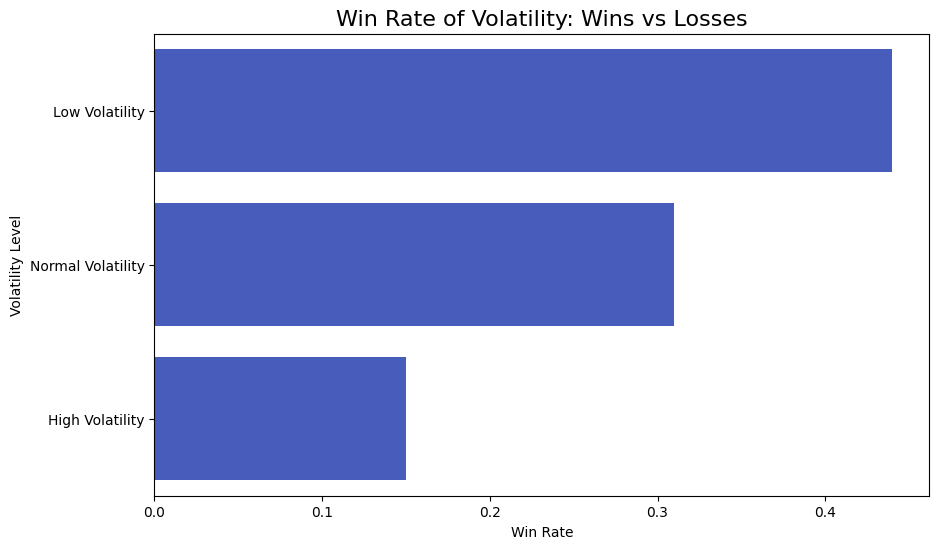

In [52]:
# Visualize volatility outcome
plt.figure(figsize=(10, 6))
sns.barplot(
    data=volatility_pivot[volatility_pivot['Total_trades'] >= 5].sort_values(by='Win_rate', ascending=False),
    x='Win_rate',   
    y='pip_range_binned',
    color='#3450ce'
)

plt.title('Win Rate of Volatility: Wins vs Losses', fontsize=16)
plt.xlabel('Win Rate')
plt.ylabel('Volatility Level')
plt.show()

In [54]:
dataframe[dataframe['pip_range_binned'] == 'High Volatility']['pip_range'].describe()

count     13.000000
mean     121.238462
std       30.210168
min      104.400000
25%      105.900000
50%      107.800000
75%      114.900000
max      207.200000
Name: pip_range, dtype: float64

It is clear from the analysis that volatility levels in terms of pip range have a significant impact on trade outcomes.  
Periods of low volatility yield highest win rate(44%), while high volatility periods are associated with lower success rates despite Normal Volatility having the highest trading volume.  

The strategy is most effective when price action is less erratic, underpinning that it is a mean-reversion and range-bound strategy that profits from predictable, slow movements.

- **Profit Factor against Wins and Losses**

In [25]:
# Group by 'pip_range_binned', and 'Volatility'
volatility_data = (
    dataframe.groupby('pip_range_binned')['Profit_loss']
            .sum()
            .to_frame()
            .reset_index())
volatility_data

,pip_range_binned,Profit_loss
0,High Volatility,-195.50
1,Low Volatility,45.88
2,Normal Volatility,-98.79
3,Unknown,-5.20


### **5.1.2 Hypothesis Testing: Targeting and Execution Failure**   
This analysis will evaluate the quality of predictive signal, by drilling into specific **Entry** and **Confirmation**  variables to find which entry signal perform better and can be reliable